In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import scipy
import scipy.stats as st
import string
import warnings
import pickle

import os
import glob
import random
from time import time

### function - get body part location for each pair of cameras

In [2]:
from ana_functions.body_part_locs_singlecam import body_part_locs_singlecam

### function - find social gaze time point

In [3]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_singlecam import find_socialgaze_timepoint_singlecam
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody import find_socialgaze_timepoint_singlecam_wholebody

### function - define time point of behavioral events

In [4]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_singlecam import bhv_events_timepoint_singlecam

### function - plot behavioral events

In [5]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - plot inter-pull interval

In [6]:
from ana_functions.plot_interpull_interval import plot_interpull_interval

### function - make demo videos with skeleton and inportant vectors

In [7]:
from ana_functions.tracking_video_singlecam_demo import tracking_video_singlecam_demo
from ana_functions.tracking_video_singlecam_wholebody_demo import tracking_video_singlecam_wholebody_demo

### function - interval between all behavioral events

In [8]:
from ana_functions.bhv_events_interval import bhv_events_interval

## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)

In [116]:
# instead of using gaze angle threshold, use the target rectagon to deside gaze info
# ...need to update
sqr_thres_tubelever = 75 # draw the square around tube and lever
sqr_thres_face = 1.15 # a ratio for defining face boundary
sqr_thres_body = 1 # how many times to enlongate the face box boundry to the body; 4: most used; 1: no enlongation


# get the fps of the analyzed video
fps = 30

# frame number of the demo video
# nframes = 0.5*30 # second*30fps
nframes = 10*30 # second*30fps

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 0

# only analyze the best (five) sessions for each conditions
do_bestsession = 1
if do_bestsession:
    savefile_sufix = '_bestsessions'
else:
    savefile_sufix = ''
    
# all the videos (no misaligned ones)
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used

# Koala Vermelho
if 1:
    if not do_bestsession:
        dates_list = [
                      "20230801","20230802","20230804","20230808","20230809","20230810",
                      "20230811","20230816","20230822","20230823","20230918","20231002",                   
                     ]
        session_start_times = [ 
                                 19.5, 24.0, 20.0, 49.5, 40.8, 32.0,
                                 40.2, 22.5, 25.5, 25.8, 28.0, 25.0, 
                              ] # in second 
    elif do_bestsession:
        dates_list = [
                      "20230801","20230802","20230804","20230808","20230809","20230810",
                      "20230811","20230816","20230822","20230823","20230918","20231002",                   
                     ]
        session_start_times = [ 
                                 19.5, 24.0, 20.0, 49.5, 40.8, 32.0,
                                 40.2, 22.5, 25.5, 25.8, 28.0, 25.0, 
                              ] # in second 
    
    animal1_fixedorder = ['koala']
    animal2_fixedorder = ['vermelho']

    animal1_filename = "Koala"
    animal2_filename = "Vermelho"
    

#
#dates_list = ["20231002"]
#session_start_times = [0.00] # in second

ndates = np.shape(dates_list)[0]

session_start_frames = session_start_times * fps # fps is 30Hz

totalsess_time = 20*60

# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']

# location of levers and tubes for camera 2
# get this information using DLC animal tracking GUI, the results are stored: 
# /home/ws523/marmoset_tracking_DLCv2/marmoset_tracking_with_lever_tube-weikang-2023-04-13/labeled-data/
considerlevertube = 1
considertubeonly = 0

# which camera to analyzed
# cameraID = 'camera-1'
# cameraID_short = 'cam1'
cameraID = 'camera-2'
cameraID_short = 'cam2'

# # camera 1
# lever_locs_camI = {'dodson':np.array([980,530]),'scorch':np.array([980,530])}
# tube_locs_camI  = {'dodson':np.array([750,315]),'scorch':np.array([1200, 280])}
# # camera 2
lever_locs_camI = {'dodson':np.array([910,560]),'scorch':np.array([910,560])}
tube_locs_camI  = {'dodson':np.array([1210,700]),'scorch':np.array([620, 700])}


if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()

    
# define bhv events summarizing variables     
succ_rate_all_dates = np.zeros((ndates,1))
interpullintv_all_dates = np.zeros((ndates,1))
trialnum_all_dates = np.zeros((ndates,1))
blocktime_all_dates = np.zeros((ndates,1))
totalsess_time_all_dates = np.zeros((ndates,1))
#
owgaze1_num_all_dates = np.zeros((ndates,1))
owgaze2_num_all_dates = np.zeros((ndates,1))
mtgaze1_num_all_dates = np.zeros((ndates,1))
mtgaze2_num_all_dates = np.zeros((ndates,1))
pull1_num_all_dates = np.zeros((ndates,1))
pull2_num_all_dates = np.zeros((ndates,1))
#
bhv_intv_all_dates = dict.fromkeys(dates_list, [])
#
# task 1 - competition
trialnum_task1_all_dates = np.zeros((ndates,1))
blocktime_task1_all_dates = np.zeros((ndates,1))
owgaze1_num_task1_all_dates = np.zeros((ndates,1))
owgaze2_num_task1_all_dates = np.zeros((ndates,1))
mtgaze1_num_task1_all_dates = np.zeros((ndates,1))
mtgaze2_num_task1_all_dates = np.zeros((ndates,1))
pull1_num_task1_all_dates = np.zeros((ndates,1))
pull2_num_task1_all_dates = np.zeros((ndates,1))
# task 2 - dilemma
trialnum_task2_all_dates = np.zeros((ndates,1))
blocktime_task2_all_dates = np.zeros((ndates,1))
owgaze1_num_task2_all_dates = np.zeros((ndates,1))
owgaze2_num_task2_all_dates = np.zeros((ndates,1))
mtgaze1_num_task2_all_dates = np.zeros((ndates,1))
mtgaze2_num_task2_all_dates = np.zeros((ndates,1))
pull1_num_task2_all_dates = np.zeros((ndates,1))
pull2_num_task2_all_dates = np.zeros((ndates,1))



# where to save the summarizing data
data_saved_folder = '/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/3d_recontruction_analysis_joystick_task_data_saved/'
if not os.path.exists(data_saved_folder):
    os.makedirs(data_saved_folder)

    

In [119]:
# basic behavior analysis (define time stamps for each bhv events, etc)

try:
    if redo_anystep:
        dummy
    
    # load saved data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    
    with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/totalsess_time_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        totalsess_time_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/blocktime_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        blocktime_all_dates = pickle.load(f)
    #
    with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        bhv_intv_all_dates = pickle.load(f)
        
    # load task 1 data
    with open(data_saved_subfolder+'/owgaze1_num_task1_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze1_num_task1_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/owgaze2_num_task1_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze2_num_task1_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze1_num_task1_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze1_num_task1_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze2_num_task1_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze2_num_task1_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_num_task1_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull1_num_task1_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_num_task1_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull2_num_task1_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/blocktime_task1_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        blocktime_task1_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialnum_task1_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        trialnum_task1_all_dates = pickle.load(f)
        
    # load task 2 data
    with open(data_saved_subfolder+'/owgaze1_num_task2_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze1_num_task2_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/owgaze2_num_task2_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze2_num_task2_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze1_num_task2_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze1_num_task2_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze2_num_task2_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze2_num_task2_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_num_task2_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull1_num_task2_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_num_task2_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull2_num_task2_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/blocktime_task2_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        blocktime_task2_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialnum_task2_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        trialnum_task2_all_dates = pickle.load(f)

    print('all data from all dates are loaded')

except:

    print('analyze all dates')

    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        session_start_time = session_start_times[idate]

        # folder and file path
        camera12_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_joystick_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
        
        singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_top_cameraMay3shuffle1_150000"
        bodyparts_camI_camIJ = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
        # get the bodypart data from files
        bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,cameraID,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,date_tgt)
        video_file_original = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"
      
        
        # load behavioral results
        try:
            bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_joystick_task/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
        except:
            bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_joystick_task/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])

        # get animal info from the session information
        animal1 = session_info['animal1_name'][0].lower()
        animal2 = session_info['animal2_name'][0].lower()
        
        # if one of the animals is blocked from the lever
        try:
            animal1_block = session_info['animal1_block']
            animal2_block = session_info['animal2_block']
        except:
            animal1_block = 0
            animal2_block = 0

        # 
        highvalue = session_info['large_reward_volume'][0]
        lowvalue = session_info['small_reward_volume'][0]

        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
            ind = bhv_data["trial_number"]==itrial+1
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]

        # get the tasktype pertrial and separate the time for each task type
        tasktype_pertrial = trial_record_clean['task_type']
        tasktype_unique = np.unique(tasktype_pertrial)
        if np.shape(tasktype_unique)[0]>1:
            ifAlterTask = 1 # this session has alternating task type
            #
            # trial for task 1 - competition
            ind_task1 = tasktype_pertrial == np.sort(np.unique(tasktype_pertrial))[0]
            trialnum_task1 = trial_record_clean['trial_number'][ind_task1].reset_index(drop=True)
            bhv_data_task1 = bhv_data[np.isin(bhv_data["trial_number"],trialnum_task1)]
            #
            nsemiblocks_task1 = np.sum(trialnum_task1.diff()>1) + 1
            semiblocks_starttrial_task1 = np.append(np.array([trialnum_task1.iloc[0]]),np.array(trialnum_task1[trialnum_task1.diff()>1]))
            semiblocks_endtrial_task1 = np.append(np.array(trialnum_task1[trialnum_task1.diff(-1)<-1]),np.array([trialnum_task1.iloc[-1]]))
            # semiblock time (align with the trial start)
            semiblocks_period_task1 = np.zeros((nsemiblocks_task1 ,2))
            for isemiblock in np.arange(0,nsemiblocks_task1,1):
                # start time 
                bhv_data_starttrial = bhv_data_task1[bhv_data_task1['trial_number']==semiblocks_starttrial_task1[isemiblock]]
                semiblocks_period_task1[isemiblock,0] = bhv_data_starttrial[bhv_data_starttrial['behavior_events']==0]['time_points']
                # end time 
                bhv_data_endtrial = bhv_data_task1[bhv_data_task1['trial_number']==semiblocks_endtrial_task1[isemiblock]]
                semiblocks_period_task1[isemiblock,1] = bhv_data_endtrial[bhv_data_endtrial['behavior_events']==9]['time_points']
            #
            # trial for task 2 - dilemma
            ind_task2 = tasktype_pertrial == np.sort(np.unique(tasktype_pertrial))[1]
            trialnum_task2 = trial_record_clean['trial_number'][ind_task2].reset_index(drop=True)
            bhv_data_task2 = bhv_data[np.isin(bhv_data["trial_number"],trialnum_task2)]
            #
            nsemiblocks_task2 = np.sum(trialnum_task2.diff()>1) + 1
            semiblocks_starttrial_task2 = np.append(np.array([trialnum_task2.iloc[0]]),np.array(trialnum_task2[trialnum_task2.diff()>1]))
            semiblocks_endtrial_task2 = np.append(np.array(trialnum_task2[trialnum_task2.diff(-1)<-1]),np.array([trialnum_task2.iloc[-1]]))
            # semiblock time (align with the trial start)
            semiblocks_period_task2 = np.zeros((nsemiblocks_task2 ,2))
            for isemiblock in np.arange(0,nsemiblocks_task2,1):
                # start time 
                bhv_data_starttrial = bhv_data_task2[bhv_data_task2['trial_number']==semiblocks_starttrial_task2[isemiblock]]
                semiblocks_period_task2[isemiblock,0] = bhv_data_starttrial[bhv_data_starttrial['behavior_events']==0]['time_points']
                # end time 
                bhv_data_endtrial = bhv_data_task2[bhv_data_task2['trial_number']==semiblocks_endtrial_task2[isemiblock]]
                semiblocks_period_task2[isemiblock,1] = bhv_data_endtrial[bhv_data_endtrial['behavior_events']==9]['time_points']
            #
            trialnum_task1_all_dates[idate] = np.shape(trialnum_task1)[0]
            trialnum_task2_all_dates[idate] = np.shape(trialnum_task2)[0]
      
        
        # use the total session time as the total time
        totalsess_time = np.ceil(np.max(bhv_data['time_points']))
        totalsess_time_all_dates[idate] = totalsess_time
        if not ifAlterTask:
            blocktime_all_dates[idate] = totalsess_time
            
        # get the time of each task type
        if ifAlterTask:
            semiblock_time_task1 = 0
            for isemiblock in np.arange(0,nsemiblocks_task1,1):
                semiblock_time_task1 = semiblock_time_task1+(semiblocks_period_task1[isemiblock,1]-semiblocks_period_task1[isemiblock,0])
            blocktime_task1_all_dates[idate] = semiblock_time_task1
            #
            semiblock_time_task2 = 0
            for isemiblock in np.arange(0,nsemiblocks_task2,1):
                semiblock_time_task2 = semiblock_time_task2+(semiblocks_period_task2[isemiblock,1]-semiblocks_period_task2[isemiblock,0])
            blocktime_task2_all_dates[idate] = semiblock_time_task2    
                
                
        # analyze behavior results
        # succ_rate_all_dates[idate] = np.sum(trial_record_clean["rewarded"]>0)/np.shape(trial_record_clean)[0]
        succ_rate_all_dates[idate] = np.sum((bhv_data['behavior_events']==3)|(bhv_data['behavior_events']==4))/np.sum((bhv_data['behavior_events']==1)|(bhv_data['behavior_events']==2))
        trialnum_all_dates[idate] = np.shape(trial_record_clean)[0]
        #
        pullid = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["behavior_events"])
        pulltime = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["time_points"])
        pullid_diff = np.abs(pullid[1:] - pullid[0:-1])
        pulltime_diff = pulltime[1:] - pulltime[0:-1]
        interpull_intv = pulltime_diff[pullid_diff==1]
        interpull_intv = interpull_intv[interpull_intv<10]
        mean_interpull_intv = np.nanmean(interpull_intv)
        std_interpull_intv = np.nanstd(interpull_intv)
        #
        interpullintv_all_dates[idate] = mean_interpull_intv
        # 
        if animal1 == animal1_fixedorder[0]:
            pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1) 
            pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2)
        if animal1 == animal2_fixedorder[0]:
            pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2) 
            pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1)
            
        #
        if ifAlterTask:
            if animal1 == animal1_fixedorder[0]:
                pull1_num_task1_all_dates[idate] = np.sum(bhv_data[np.isin(bhv_data['trial_number'],trialnum_task1)]['behavior_events']==1)
                pull2_num_task1_all_dates[idate] = np.sum(bhv_data[np.isin(bhv_data['trial_number'],trialnum_task1)]['behavior_events']==2)
                pull1_num_task2_all_dates[idate] = np.sum(bhv_data[np.isin(bhv_data['trial_number'],trialnum_task2)]['behavior_events']==1)
                pull2_num_task2_all_dates[idate] = np.sum(bhv_data[np.isin(bhv_data['trial_number'],trialnum_task2)]['behavior_events']==2)
            if animal1 == animal2_fixedorder[0]:
                pull1_num_task1_all_dates[idate] = np.sum(bhv_data[np.isin(bhv_data['trial_number'],trialnum_task1)]['behavior_events']==2)
                pull2_num_task1_all_dates[idate] = np.sum(bhv_data[np.isin(bhv_data['trial_number'],trialnum_task1)]['behavior_events']==1)
                pull1_num_task2_all_dates[idate] = np.sum(bhv_data[np.isin(bhv_data['trial_number'],trialnum_task2)]['behavior_events']==2)
                pull2_num_task2_all_dates[idate] = np.sum(bhv_data[np.isin(bhv_data['trial_number'],trialnum_task2)]['behavior_events']==1)
            
            
        # load behavioral event results
        try:
            # dummy
            print('load social gaze with '+cameraID+' only of '+date_tgt)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                output_look_ornot = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                output_allvectors = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
                output_allangles = pickle.load(f)  
        except:   
            print('analyze social gaze with '+cameraID+' only of '+date_tgt)
            # get social gaze information 
            output_look_ornot, output_allvectors, output_allangles = find_socialgaze_timepoint_singlecam_wholebody(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,
                                                                                                                   considerlevertube,considertubeonly,sqr_thres_tubelever,
                                                                                                                   sqr_thres_face,sqr_thres_body)
            # save data
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            #
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'wb') as f:
                pickle.dump(output_look_ornot, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'wb') as f:
                pickle.dump(output_allvectors, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'wb') as f:
                pickle.dump(output_allangles, f)
  

        look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
        look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
        look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
        # change the unit to second
        session_start_time = session_start_times[idate]
        look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 

        # find time point of behavioral events
        output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
        time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
        time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
        oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
        oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
        mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
        mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']
            
                
        # # plot behavioral events
        if np.isin(animal1,animal1_fixedorder):
                plot_bhv_events(date_tgt,animal1, animal2, session_start_time, totalsess_time, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
        else:
                plot_bhv_events(date_tgt,animal2, animal1, session_start_time, totalsess_time, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)
        #
        # save behavioral events plot
        if 0:
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            plt.savefig(data_saved_folder+"/bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/'+date_tgt+"_"+cameraID_short+".pdf")

        #
        if animal1 == animal1_fixedorder[0]:
            owgaze1_num_all_dates[idate] = np.shape(oneway_gaze1)[0]
            owgaze2_num_all_dates[idate] = np.shape(oneway_gaze2)[0]
            mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze1)[0]
            mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze2)[0]
        if animal1 == animal2_fixedorder[0]:
            owgaze1_num_all_dates[idate] = np.shape(oneway_gaze2)[0]
            owgaze2_num_all_dates[idate] = np.shape(oneway_gaze1)[0]
            mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze2)[0]
            mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze1)[0]
        #
        if ifAlterTask:
            # task 1
            owgaze1_num_task1 = 0
            mtgaze1_num_task1 = 0
            owgaze2_num_task1 = 0
            mtgaze2_num_task1 = 0
            for isemiblock in np.arange(0,nsemiblocks_task1,1):
                owgaze1_num_task1 = owgaze1_num_task1+np.sum((oneway_gaze1>semiblocks_period_task1[isemiblock,0])&(oneway_gaze1<semiblocks_period_task1[isemiblock,1]))
                mtgaze1_num_task1 = mtgaze1_num_task1+np.sum((mutual_gaze1>semiblocks_period_task1[isemiblock,0])&(mutual_gaze1<semiblocks_period_task1[isemiblock,1]))
                owgaze2_num_task1 = owgaze2_num_task1+np.sum((oneway_gaze2>semiblocks_period_task1[isemiblock,0])&(oneway_gaze2<semiblocks_period_task1[isemiblock,1]))
                mtgaze2_num_task1 = mtgaze2_num_task1+np.sum((mutual_gaze2>semiblocks_period_task1[isemiblock,0])&(mutual_gaze2<semiblocks_period_task1[isemiblock,1]))
            if animal1 == animal1_fixedorder[0]:
                owgaze1_num_task1_all_dates[idate] = owgaze1_num_task1
                owgaze2_num_task1_all_dates[idate] = owgaze2_num_task1
                mtgaze1_num_task1_all_dates[idate] = mtgaze1_num_task1
                mtgaze2_num_task1_all_dates[idate] = mtgaze2_num_task1 
            if animal1 == animal2_fixedorder[0]:
                owgaze1_num_task1_all_dates[idate] = owgaze2_num_task1
                owgaze2_num_task1_all_dates[idate] = owgaze1_num_task1
                mtgaze1_num_task1_all_dates[idate] = mtgaze2_num_task1
                mtgaze2_num_task1_all_dates[idate] = mtgaze1_num_task1 
            # task 2
            owgaze1_num_task2 = 0
            mtgaze1_num_task2 = 0
            owgaze2_num_task2 = 0
            mtgaze2_num_task2 = 0
            for isemiblock in np.arange(0,nsemiblocks_task2,1):
                owgaze1_num_task2 = owgaze1_num_task2+np.sum((oneway_gaze1>semiblocks_period_task2[isemiblock,0])&(oneway_gaze1<semiblocks_period_task2[isemiblock,1]))
                mtgaze1_num_task2 = mtgaze1_num_task2+np.sum((mutual_gaze1>semiblocks_period_task2[isemiblock,0])&(mutual_gaze1<semiblocks_period_task2[isemiblock,1]))
                owgaze2_num_task2 = owgaze2_num_task2+np.sum((oneway_gaze2>semiblocks_period_task2[isemiblock,0])&(oneway_gaze2<semiblocks_period_task2[isemiblock,1]))
                mtgaze2_num_task2 = mtgaze2_num_task2+np.sum((mutual_gaze2>semiblocks_period_task2[isemiblock,0])&(mutual_gaze2<semiblocks_period_task2[isemiblock,1]))
            if animal1 == animal1_fixedorder[0]:
                owgaze1_num_task2_all_dates[idate] = owgaze1_num_task2
                owgaze2_num_task2_all_dates[idate] = owgaze2_num_task2
                mtgaze1_num_task2_all_dates[idate] = mtgaze1_num_task2
                mtgaze2_num_task2_all_dates[idate] = mtgaze2_num_task2  
            if animal1 == animal2_fixedorder[0]:
                owgaze1_num_task2_all_dates[idate] = owgaze2_num_task2
                owgaze2_num_task2_all_dates[idate] = owgaze1_num_task2
                mtgaze1_num_task2_all_dates[idate] = mtgaze2_num_task2
                mtgaze2_num_task2_all_dates[idate] = mtgaze1_num_task2  

        

        # analyze the events interval, especially for the pull to other and other to pull interval
        # could be used for define time bin for DBN
        if 1:
            _,_,_,pullTOother_itv, otherTOpull_itv = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, 
                                                                         oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            #
            pull_other_pool_itv = np.concatenate((pullTOother_itv,otherTOpull_itv))
            bhv_intv_all_dates[date_tgt] = {'pull_to_other':pullTOother_itv,'other_to_pull':otherTOpull_itv,
                            'pull_other_pooled': pull_other_pool_itv}
        
        # plot the tracking demo video
        if 0: 
            tracking_video_singlecam_wholebody_demo(bodyparts_locs_camI,output_look_ornot,output_allvectors,output_allangles,
                                              lever_locs_camI,tube_locs_camI,time_point_pull1,time_point_pull2,
                                              animalnames_videotrack,bodypartnames_videotrack,date_tgt,
                                              animal1_filename,animal2_filename,session_start_time,fps,nframes,cameraID,
                                              video_file_original,sqr_thres_tubelever,sqr_thres_face,sqr_thres_body)         
        

    # save data
    if 1:
        
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
                
        # with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
        #     pickle.dump(DBN_input_data_alltypes, f)

        with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull1_num_all_dates, f)
        with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull2_num_all_dates, f)
        with open(data_saved_subfolder+'/totalsess_time_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(totalsess_time_all_dates, f)
        with open(data_saved_subfolder+'/blocktime_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(blocktime_all_dates, f)
        #
        with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(succ_rate_all_dates, f)
        with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(interpullintv_all_dates, f)
        with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(trialnum_all_dates, f)
        with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(bhv_intv_all_dates, f)
    
        # task 1
        with open(data_saved_subfolder+'/trialnum_task1_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(trialnum_task1_all_dates, f)
        with open(data_saved_subfolder+'/pull1_num_task1_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull1_num_task1_all_dates, f)
        with open(data_saved_subfolder+'/pull2_num_task1_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull2_num_task1_all_dates, f)
        with open(data_saved_subfolder+'/owgaze1_num_task1_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze1_num_task1_all_dates, f)
        with open(data_saved_subfolder+'/owgaze2_num_task1_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze2_num_task1_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze1_num_task1_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze1_num_task1_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze2_num_task1_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze2_num_task1_all_dates, f)  
        with open(data_saved_subfolder+'/blocktime_task1_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(blocktime_task1_all_dates, f)
        
        # task 2
        with open(data_saved_subfolder+'/trialnum_task2_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(trialnum_task2_all_dates, f)
        with open(data_saved_subfolder+'/pull1_num_task2_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull1_num_task2_all_dates, f)
        with open(data_saved_subfolder+'/pull2_num_task2_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull2_num_task2_all_dates, f)
        with open(data_saved_subfolder+'/owgaze1_num_task2_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze1_num_task2_all_dates, f)
        with open(data_saved_subfolder+'/owgaze2_num_task2_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze2_num_task2_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze1_num_task2_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze1_num_task2_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze2_num_task2_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze2_num_task2_all_dates, f)  
        with open(data_saved_subfolder+'/blocktime_task2_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(blocktime_task2_all_dates, f)
            
            

all data from all dates are loaded


## figure plot
### plot the gaze number/block time; task 1 vs task 2

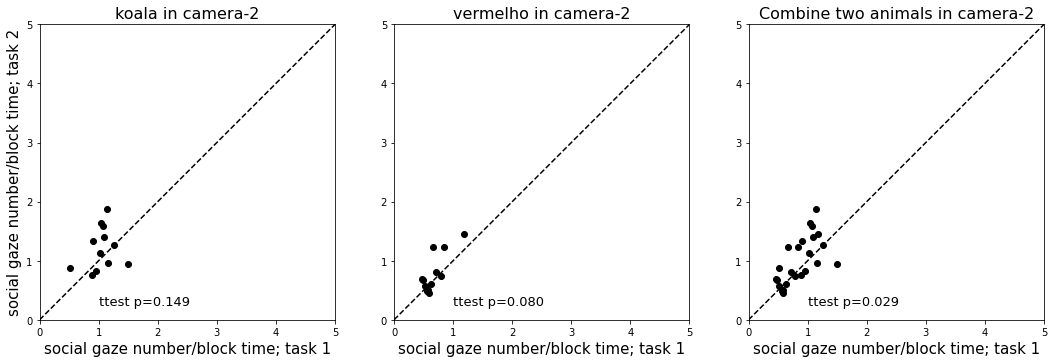

In [120]:
fig, axs = plt.subplots(1,3)
fig.set_figheight(6)
fig.set_figwidth(18)


# animal 1 gaze 
xxx = (mtgaze1_num_task1_all_dates+owgaze1_num_task1_all_dates)/blocktime_task1_all_dates
yyy = (mtgaze1_num_task2_all_dates+owgaze1_num_task2_all_dates)/blocktime_task2_all_dates
axs[0].plot(xxx,yyy,'ko')
axs[0].plot([0,5],[0,5],'k--')
axs[0].set_xlim([0,5])
axs[0].set_ylim([0,5])
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('social gaze number/block time; task 1',fontsize = 15)
axs[0].set_ylabel('social gaze number/block time; task 2',fontsize = 15)
sts = scipy.stats.ttest_rel(xxx,yyy)
pvalue = sts.pvalue
axs[0].text(1,0.25,'ttest p='+"{:.3f}".format(pvalue[0]),fontsize=13)
axs[0].set_title(animal1_fixedorder[0]+' in '+cameraID,fontsize=16)

# animal 2 gaze 
xxx = (mtgaze2_num_task1_all_dates+owgaze2_num_task1_all_dates)/blocktime_task1_all_dates
yyy = (mtgaze2_num_task2_all_dates+owgaze2_num_task2_all_dates)/blocktime_task2_all_dates
axs[1].plot(xxx,yyy,'ko')
axs[1].plot([0,5],[0,5],'k--')
axs[1].set_xlim([0,5])
axs[1].set_ylim([0,5])
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('social gaze number/block time; task 1',fontsize = 15)
sts = scipy.stats.ttest_rel(xxx,yyy)
pvalue = sts.pvalue
axs[1].text(1,0.25,'ttest p='+"{:.3f}".format(pvalue[0]),fontsize=13)
axs[1].set_title(animal2_fixedorder[0]+' in '+cameraID,fontsize=16)


# both animals gaze 
xxx1 = (mtgaze1_num_task1_all_dates+owgaze1_num_task1_all_dates)/blocktime_task1_all_dates
yyy1 = (mtgaze1_num_task2_all_dates+owgaze1_num_task2_all_dates)/blocktime_task2_all_dates
xxx2 = (mtgaze2_num_task1_all_dates+owgaze2_num_task1_all_dates)/blocktime_task1_all_dates
yyy2 = (mtgaze2_num_task2_all_dates+owgaze2_num_task2_all_dates)/blocktime_task2_all_dates
xxx = np.vstack([xxx1,xxx2])
yyy = np.vstack([yyy1,yyy2])
axs[2].plot(xxx,yyy,'ko')
axs[2].plot([0,5],[0,5],'k--')
axs[2].set_xlim([0,5])
axs[2].set_ylim([0,5])
axs[2].set_aspect('equal', adjustable='box')
axs[2].set_xlabel('social gaze number/block time; task 1',fontsize = 15)
sts = scipy.stats.ttest_rel(xxx,yyy)
pvalue = sts.pvalue
axs[2].text(1,0.25,'ttest p='+"{:.3f}".format(pvalue[0]),fontsize=13)
axs[2].set_title('Combine two animals in '+cameraID,fontsize=16)


savefigs = 1
if savefigs:
    plt.savefig("gazenum_perblocktime_task1VStask2"+animal1_fixedorder[0]+animal2_fixedorder[0]+"_"+cameraID+".pdf")